# Hands-On Perception: Event-based Data and Motion Compensation
## Event-based Cameras
Event-based Cameras (EBCs) are imaging sensors that respond to local brightness changes.
Unlike conventional frame-based cameras, EBCs are asynchronous, having each pixel operating
independently from the other. Each pixel reports a change of intensity (if it occurs), or
stays silent otherwise. For example, a pixel stores a reference intensity at time $t$, the
current intensity is then compared to the reference at time $t + 1$. If the aforementioned
difference exceeds the threshold, that pixel outputs an **"event"**.

An "event" is a discrete packet of information containing:
* Event location ($x$ and $y$ coordinates, across the height and width dimensions respectively).
* Event timestamps $t$. The time at which the event occurred.
* Event polarity $p$. The direction of intensity change. It does not contain any information
regarding intensity values. It is an output spike that can either be $+1$, or $-1$.


## Data Structure
### Dataset
For the sake of this lab, we will be using the **"MVSEC"** dataset. The "MVSEC" dataset is
designed for the development of novel 3D perception algorithms for EBCs. In fact, stereo
event-based data is collected from cars, motorbikes, hexacopters and handhelds, fused with
LiDAR, IMU, motion-capture and GPS systems to provide ground truth pose and depth images.

> **Note:**
> You can read more about the "MVSEC" dataset [here](https://daniilidis-group.github.io/mvsec/).
> Before starting this lab, it is important to understand the data structure of "MVSEC".
> This dataset has been taken with a DAVIS346B sensor of resolution **(260, 346)**.

### Dataset Loading
The available dataset is in **".hdf5"** format. This format is excellent for manipulating huge
datasets since it supports data grouping and sub-grouping. Moreover, ".hdf5" files can be
manipulated **without loading all the data in memory**, making it much more manageable since
event-based data can take up to 20x the space required for traditional frame-based videos.

Each ".hdf5" file contains **four** main components:
- **Events:** The events data which consists of one array of shape (*num_events*, *4*),
where the second dimension corresponds to (*x*, *y*, *t*, *p*) respectively. The
timestamps appear as big values since they are recorded with ROS time. As for the
polarities they are either *-1* or *+1*, depending on the direction of intensity change
relative to each event.
- **Grayscale Images:** The extracted grayscale images which consist of one array of shape
(*num_frames*, *H*, *W*). The grayscale images are extracted in sequence, from the first
frame till the last one in the dataset.
- **Grayscale Timestamps:** The timestamp of each grayscale image in the form of a 1D
array of shape (*num_frames*), in which the index of each element relates to its
corresponding frame in the "Grayscale Images" array.
- **Nearest Events:** The term "nearest events" alludes to the index of the event in the
"Events" array that is closest to each grayscale frame. The data is a 1D array of shape
(*num_frames*), it is always equal to the number of available grayscale frames.

Similar to a file manager, a ".hdf5" file consists of hierarchical directories:
- **Events** are found in **"davis", "left", "events"**
- **Grayscale images** are found in **"davis", "left", "image_raw"**
- **Grayscale timestamps** are found in **"davis", "left", "image_raw_ts"**
- **Nearest events** are found in **"davis", "left", "image_raw_event_inds"**

### Ground Truth Loading
All ground truth flow datasets contain the postfix **"_gt.hdf5"** at the end of their filenames.
Each ground truth ".hdf5" file contains **2** main components:
- **Ground Truth Flow:** The extracted ground truth flow which consists of one array of shape
(*num_samples*, 2, *H*, *W*). Where the 2 channels correspond to the flows in the **x-direction**
and **y-direction** respectively.
- **Ground Truth Timestamps:** The timestamp of each ground truth sample in the form of a 1D
array of shape (*num_frames*), in which the index of each element relates to its
corresponding sample in the "Ground Truth Flow" array.

Similar to a file manager, a ".hdf5" file consists of hierarchical directories:
- **Ground Truth Flow** is found in **"davis", "left", "flow_dist"**
- **Ground Truth Timestamps** are found in **"davis", "left", "flow_dist_ts"**

### eWiz Library
To load and manipulate the dataset, we will be using our own **"eWiz"** library for event-based data reading
and manipulation. The "eWiz" library contains a series of modules, which include, but is not
limited to:
* **Data Reading:** Reads and clips event-based and ground truth flow data in ".hdf5" format.
* **Sequence Rendering:** Renders event-based sequences as 3D volumes or 2D videos.
* **Data Augmentations:** Applies temporal and spatial augmentations to event-based data and
corresponding grayscale images.
* **Accuracy Metrics**: Provides several accuracy metrics for optical flow evaluation, such
as the Average Endpoint Error (AEE), and the percentage of outliers.
* **Visualizations**: Provides visualization functions for optical flow, event-based data,
and grayscale images.

## **Part 1:** Data Loading
In this part, you will be looking at the full sequence of one of the datasets. Your tasks are:
1. Choose any dataset of your liking (two ".hdf5" files, ground truth and data).
2. Load the desired dataset with the 'DataReader' class.
3. Render that data in video format, and choose a sequence of **0.2 s**, in which you observe
a clear movement in one direction.

### Import necessary packages

In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, List, Dict

In [12]:
# Import eWiz modules
from ewiz.core.reader import read_data, read_gt, clip_data
from ewiz.renderers import Renderer

# ===== Replace variables here =====
"""
Fill the empty string cells below. Choose your data directories, and '.hdf5' groups as
stated in the lab's given.
"""
# Directory variables
data_dir = "indoor_flying1_data.hdf5"
gt_dir = "indoor_flying1_gt.hdf5"

data_file = h5py.File(data_dir, "r")
data = read_data(
    data_file=data_file,
    events_group=["davis", "left", "events"],
    nearest_events_group=["davis", "left", "image_raw_event_inds"],
    grayscale_images_group=["davis", "left", "image_raw"],
    grayscale_timestamps_group=["davis", "left", "image_raw_ts"],
    reset_time=True
)

# Data variables
events = data[0]
nearest_events = data[1]
grayscale_images = data[2]
grayscale_timestamps = data[3]

# Print data
print("Events Timestamps:", events[:, 2])
print("Grayscale Timestamps:", grayscale_timestamps)
# ==================================

# ===== Render here =====
"""
Main rendering script. You need to:
* Input the correct image size of shape (H, W) (resolution available on MVSEC site).
* Choose desired format (choose 'volume' for 3D rendering, 'video' for 2D rendering).
* You can adjust refresh rate and number of events to your liking (to get smoother video).
"""
renderer = Renderer(
    image_size=(260, 346),
    events=events,
    grayscale_images= grayscale_images,
    grayscale_timestamps=grayscale_timestamps,
    rendering_format="video",
    rendering_method="slide",
    num_events=30000,
    refresh_rate=40
)
renderer.run()
# =======================

Events Timestamps: [0.00000000e+00 6.91413879e-06 1.14917755e-04 ... 7.02886331e+01
 7.02888551e+01 7.02897389e+01]
Grayscale Timestamps: [2.36830711e-02 5.55419922e-02 8.74021053e-02 ... 7.02098639e+01
 7.02417240e+01 7.02735829e+01]


### Sequence Clipping
Choose a sequence where you can clearly see objects moving in one direction. The sequence
should be **0.2 s** long. Rerun the algorithm **(below)** above with your desired starting
`start_time` and final `end_time` timestamps in seconds.

**Write your timestamps in the sentence below:**

Sequence is clipped between <span style="color:red">0.0</span> s and <span style="color:red">0.0</span> s.

In [13]:
"""
Modify 'start_time' and 'end_time' below.
"""
data_file = h5py.File(data_dir, "r")
data = read_data(
    data_file=data_file,
    events_group=["davis", "left", "events"],
    nearest_events_group=["davis", "left", "image_raw_event_inds"],
    grayscale_images_group=["davis", "left", "image_raw"],
    grayscale_timestamps_group=["davis", "left", "image_raw_ts"],
    reset_time=True
)

# Data variables
events = data[0]
nearest_events = data[1]
grayscale_images = data[2]
grayscale_timestamps = data[3]

# 0.2s clipped sequence
# data = clip_data(
#     start_time=20,
#     end_time=20.2,
#     events=events,
#     nearest_events=nearest_events,
#     grayscale_images=grayscale_images,
#     grayscale_timestamps=grayscale_timestamps
# )

# 1s clipped sequence
data = clip_data(
    start_time=20,
    end_time=21,
    events=events,
    nearest_events=nearest_events,
    grayscale_images=grayscale_images,
    grayscale_timestamps=grayscale_timestamps
)

# Data variables
events = data[0]
nearest_events = data[1]
grayscale_images = data[2]
grayscale_timestamps = data[3]

# NOTE: No need to render since sequence is very short!
# ===== Render here =====

"""
Check if this is the correct sequence that you require.
"""
renderer = Renderer(
    image_size=(260, 346),
    events=events,
    grayscale_images=grayscale_images,
    grayscale_timestamps=grayscale_timestamps,
    rendering_format="video",
    rendering_method="slide",
    num_events=30000,
    refresh_rate=40
)
renderer.run()
# =======================

## **Part 2:** Data Manipulation
Event-based data is **asynchronous**, meaning that unlike intensity frame-based cameras,
EBCs do not output data at a fixed frequency. This might be a problem for traditional
neural network architectures (or computer vision algorithms) as they require data given
**synchronously**. Moreover, EBCs are considered a **paradigm shift** as they do not output
traditional images. As such, if we want to work with convolutional neural networks (CNNs)
this event-based data (the array you printed previously) should be converted to an
**image-like** equivalent. This is what we call **events-to-image encoding**, which converts
event-based data to a **traditional image** (either grayscale, RGB, or 2-channels).

For the sake of this lab, let's start by creating a simple events image. Using the
"events" data you printed earlier, we want to insert each event in its respective pixel
location, for which each channel corresponds to a different polarity. As such, the output
image will have the shape *(C, H, W)*, where:
- **C:** The **channel** dimension (its value is 2), the first element encapsulates positive
polarities, whereas the second element encapsulates negative polarities.
- **H:** The **height** dimension, which corresponds to the y-dimension (depends on the camera
resolution).
- **W:** The **width** dimension, which corresponds to the x-dimension (depends on the camera
resolution).

Each pixel value should correspond to the number of events that took place at that pixel
location (sum of events, or "count" method).

Your job is to:
- Convert extracted events to an image representation, fill the `convert_events_to_image` function.
- Use the provided visualization functions to visualize the images:
    - A heatmap representation of the combined channels, printing the pixel value with the
    highest number of events.
    - An RGB image showing **positive alone**, **negative alone**, and **combined** events
    representation.

### Creating an Events Image

POSITIVE


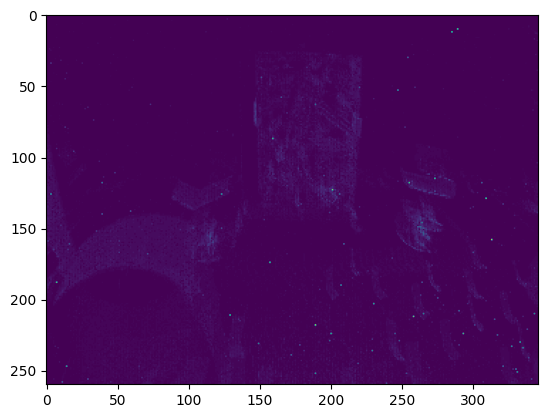

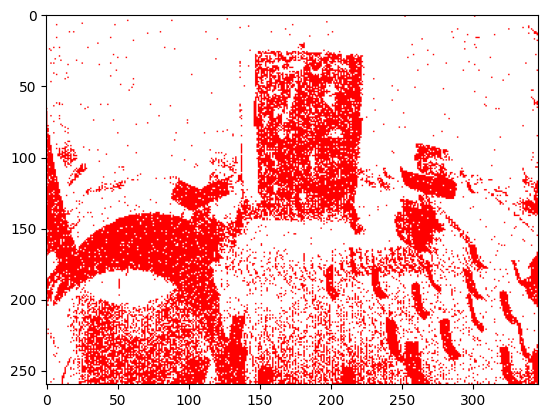

NEGATIVE


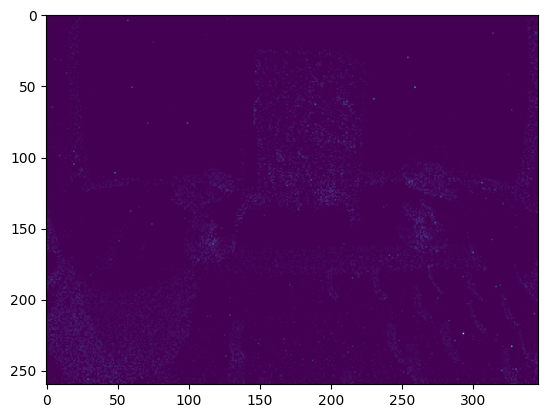

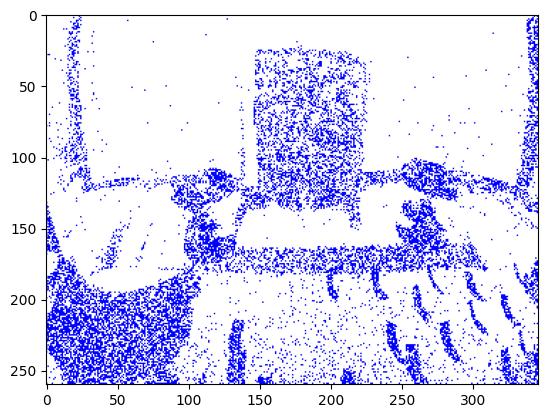

BOTH


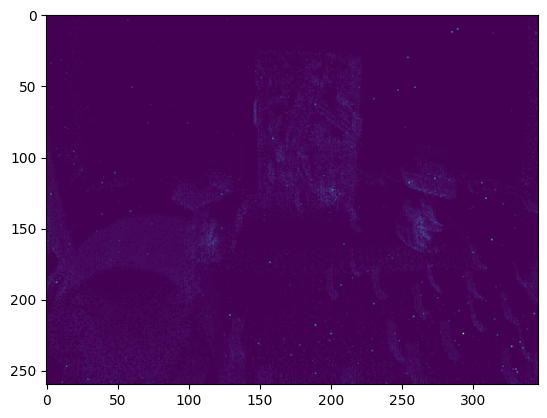

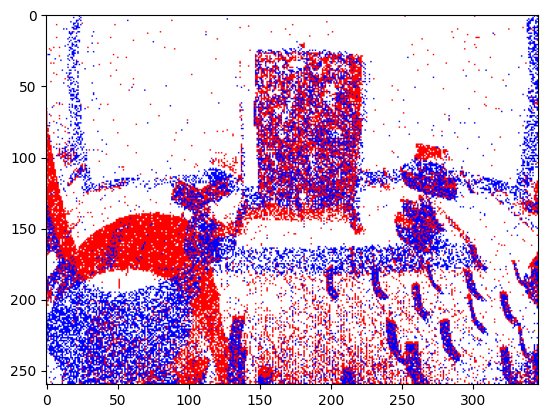

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0, 255],
        [255, 255, 255],
        [  0,   0, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0, 255],
        [255,   0,   0],
        [  0,   0, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0, 255],
        [255, 255, 255],
        [  0,   0, 255]]

In [14]:
# ===== Code inside function =====

# M events - > 1 pixel

def convert_events_to_image(events: np.ndarray, image_size: Tuple[int, int]) -> np.ndarray:
    """
    Converts a sequence of events to a 2-channel events image.

    Parameters
    ----------
    events : np.ndarray
        Events array, extracted from the '.hdf5' file.
    image_size : Tuple[int, int]
        The size of the output image, equal to the size of the sensor of format (H, W).

    Returns
    -------
    events_image : np.ndarray
        Output image of shape (2, H, W). Each pixel should contain an integer with the
        number of events that occurred at that location.
    """
    
    events_image = np.zeros((2, image_size[0], image_size[1]), dtype=np.int32)

    for event in events:
        x, y,t, p = event  
        # polarity is float so do it ( change = 1 to > 0) 
        if p > 0:
            events_image[0] [int (y), int (x)] += 1
        else:
            events_image[1] [int (y), int (x)] += 1  

    return events_image

# ================================

def visualize_events_heatmap(events_image: np.ndarray, polarity: str = "pos") -> np.ndarray:
    """
    Visualizes events heatmap based on the pixel-wise count of events.

    Parameters
    ----------
    events_image : np.ndarray
        Generated events image.
    polarity : str
        Polarity channel to show, can either be 'pos', 'neg', 'both' (defaults to 'pos').

    Returns
    -------
    image : np.ndarray
        Output image of shape (H, W).
    """
    if polarity == "pos":
        image = events_image[0, ...]
    elif polarity == "neg":
        image = events_image[1, ...]
    else:
        image = np.sum(events_image, axis=0)
    
    plt.imshow(image)
    plt.show()

    return image

def visualize_events_image_rgb(events_image: np.ndarray, polarity: str = "pos") -> np.ndarray:
    """
    Visualizes events heatmap based on the pixel-wise count of events.

    Parameters
    ----------
    events_image : np.ndarray
        Generated events image.
    polarity : str
        Polarity channel to show, can either be 'pos', 'neg', 'both' (defaults to 'pos').

    Returns
    -------
    image : np.ndarray
        Output image of shape (H, W, 3).
    """
    image_size = (events_image.shape[1], events_image.shape[2])
    image = np.zeros(((3,) + image_size), dtype=np.uint8) + 255

    if polarity == "pos":
        pos_ids = np.where(events_image[0, ...] > 0)
        image[:, pos_ids[0], pos_ids[1]] = np.array([255, 0, 0])[:, None]
    elif polarity == "neg":
        neg_ids = np.where(events_image[1, ...] > 0)
        image[:, neg_ids[0], neg_ids[1]] = np.array([0, 0, 255])[:, None]
    else:
        pos_ids = np.where(events_image[0, ...] > 0)
        neg_ids = np.where(events_image[1, ...] > 0)

        image[:, pos_ids[0], pos_ids[1]] = np.array([255, 0, 0])[:, None]
        image[:, neg_ids[0], neg_ids[1]] = np.array([0, 0, 255])[:, None]
    
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.show()

    return image

# todos : for polarity check for pos/neg/both
events_image = convert_events_to_image(events, (260, 346))
print("POSITIVE")
visualize_events_heatmap(events_image, polarity='pos')
visualize_events_image_rgb(events_image, polarity='pos')
print("NEGATIVE")
visualize_events_heatmap(events_image, polarity='neg')
visualize_events_image_rgb(events_image, polarity='neg')
print("BOTH")
visualize_events_heatmap(events_image, polarity='both')
visualize_events_image_rgb(events_image, polarity='both')

### Frame-based Approach
There exists multiple encoding schemes that have been used in the literature for the sake
of implementing event-based neural networks and algorithms. The goal behind such encoding
schemes is to discretize the events volume, meaning that we want to create a sequence of
events image frames before feeding them to the network.

Unlike the previously generated image (which encapsulates all of the clipped sequence), we
want to create **5** events frames for your clipped sequence:
* Generate an array containing all frames of shape **(C, H, W, N)**, where **N** is the frame
channel.
* Visualize **combined heatmap images** and **combined "RGB" images** frame by frame.

Frame 1:
BOTH


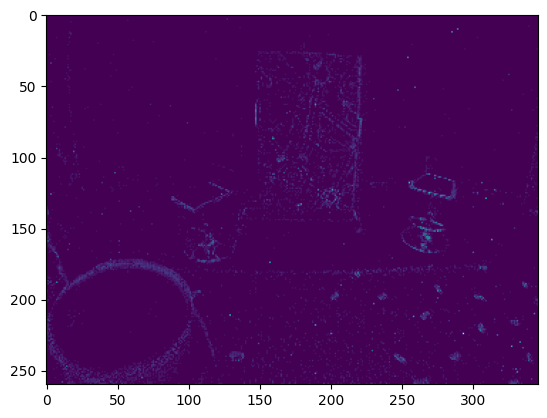

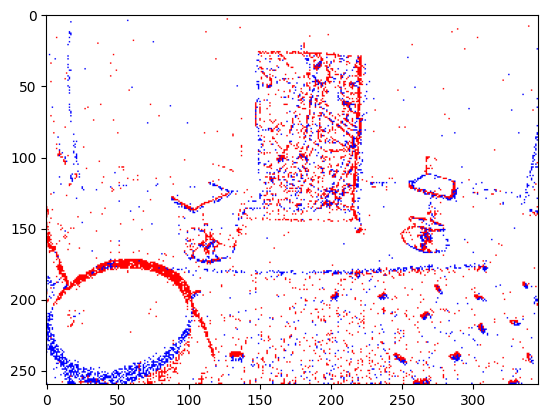

Frame 2:
BOTH


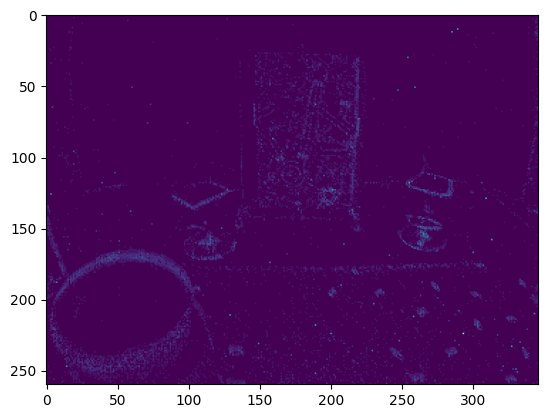

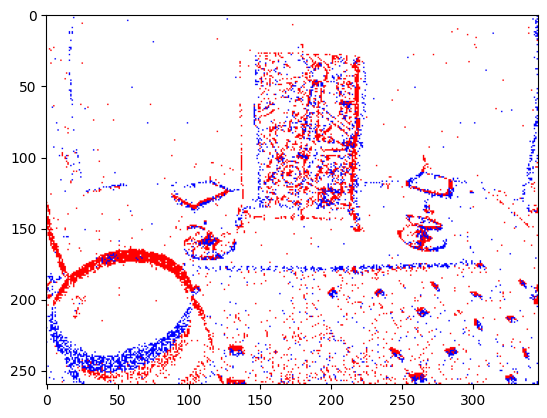

Frame 3:
BOTH


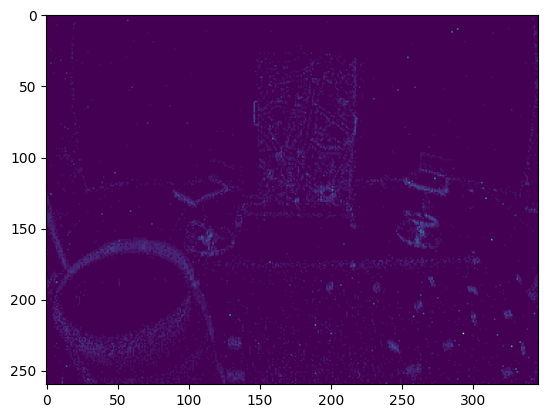

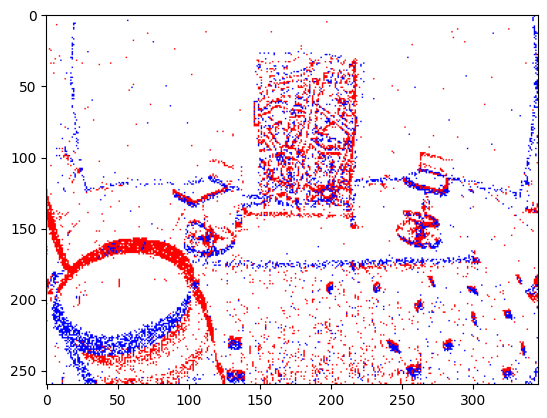

Frame 4:
BOTH


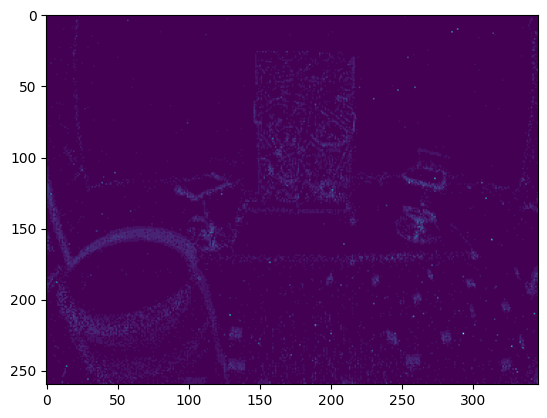

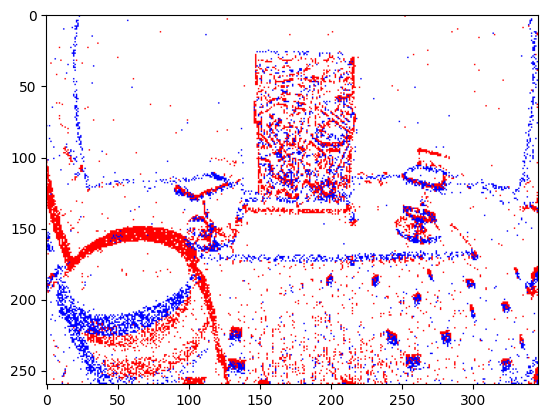

Frame 5:
BOTH


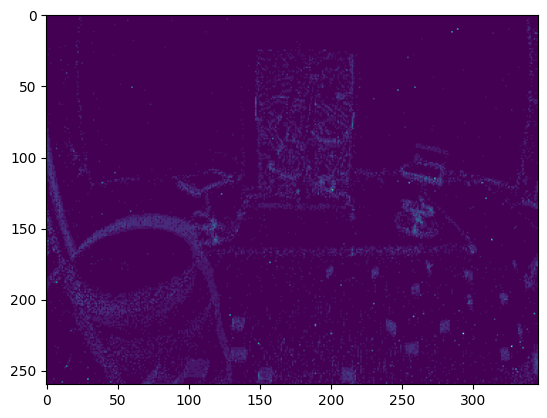

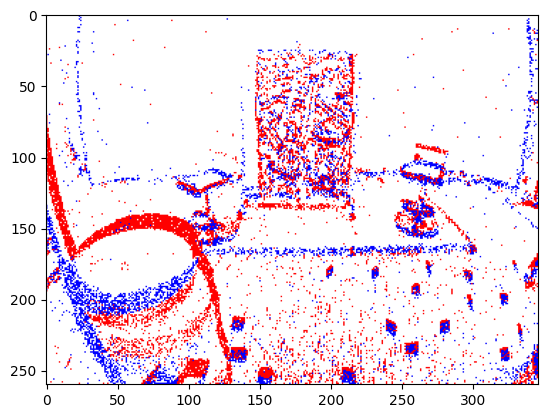

In [15]:
def generate_event_frames(events: np.ndarray, grayscale_images: np.ndarray, grayscale_timestamps: np.ndarray, num_frames: int = 5) -> np.ndarray:

    frame_interval = (grayscale_timestamps[-1] - grayscale_timestamps[0]) / num_frames

    event_frames = np.zeros((2, grayscale_images.shape[1], grayscale_images.shape[2], num_frames), dtype=np.int32)

    # each frame
    for i in range(num_frames):
        start_time = grayscale_timestamps[0] + i * frame_interval
        end_time = start_time + frame_interval

        frame_events = events[(events[:, 2] >= start_time) & (events[:, 2] < end_time)]
        # frame_grayscale_images = grayscale_images[(grayscale_timestamps >= start_time) & (grayscale_timestamps < end_time)]

        # events to image
        frame_events_image = convert_events_to_image(frame_events, (260, 346))

        # sum events
        event_frames[:, :, :, i] = frame_events_image

    return event_frames

event_frames = generate_event_frames(events, grayscale_images, grayscale_timestamps)

# Visualize combined heatmap images and combined "RGB" images frame by frame
for i in range(event_frames.shape[-1]):
    print(f"Frame {i+1}:")
    # print("POSITIVE")
    # visualize_events_heatmap(event_frames[:, :, :, i], polarity='pos')
    # visualize_events_image_rgb(event_frames[:, :, :, i], polarity='pos')
    # print("NEGATIVE")
    # visualize_events_heatmap(event_frames[:, :, :, i], polarity='neg')
    # visualize_events_image_rgb(event_frames[:, :, :, i], polarity='neg')
    print("BOTH")
    visualize_events_heatmap(event_frames[:, :, :, i], polarity='both')
    visualize_events_image_rgb(event_frames[:, :, :, i], polarity='both')

## **Questions**
> **NOTE:** Apply the tasks above for a sequence of **0.2 s**, and another for **1.0 s**.
> Images should be in report.

Answer all questions below in your report for each case (0.2 s and 1.0 s):
1. How clear is the obtained events image? Why? (Explain by showing your resulting images,
and analyzing the motion of your chosen sequence).
2. How do the images change after applying the frame-based approach? Why? (Explain by showing
your resulting images, and analyzing the motion of your chosen sequence).

One answer only for both cases:

3. For the same time duration, how would the clarity of the events image change if we increase
the camera velocity for the same scene? Explain.
4. In this lab, we only used event counts as encoding. Though this might seem a good idea,
some information remains lost. Pinpoint which information is lost with such an encoding scheme
and suggest alternatives.